In [ ]:
import cnnfeat
from cnnfeat import cnn_model, get_feats
from keras.models import Model
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import *

In [3]:
def plot_multi(im, dim=(4,4), figsize=(6,6), **kwargs ):
    plt.figure(figsize=figsize)
    for i,img in enumerate(im):
        plt.subplot(*((dim)+(i+1,)))
        plt.imshow(img, **kwargs)
        plt.axis('off')
    plt.tight_layout()

### v0

In [35]:
from keras.regularizers import l2

In [85]:
def conv_block(input_tensor, filters, kernel_size=(3,3), act=True, weight_decay=1e-6):
    # embed()
    x = Convolution2D(filters, kernel_size, strides=(1,1), padding='same', use_bias=False,
                      kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    if act:
        x = Activation('relu')(x)
    return x

def res_block(input_tensor, filters):
    x = conv_block(input_tensor, filters)
    # x = conv_block(x, filters)
    x = conv_block(x, filters, act=False)
    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [86]:
def cnn_model():
    k = 192
    net_input = Input((8,8,14))
    x = conv_block(net_input, k, kernel_size=(3,3))
    for i in range(8):
        x = res_block(x, k)
    x = conv_block(x, 1, kernel_size=(1,1))
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Dropout(.5)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    net_output = Activation('tanh')(x)
    # 5,359,494 params
    return net_input, net_output

In [87]:
net_input, net_output = cnn_model()
model = Model(net_input, net_output)
# model.summary()

In [88]:
# model.load_weights('../slonik_data/cnn_weights_epoch3.h5')
model.compile(optimizer=Adam(1e-3), loss='mse')
train_model = model

In [89]:
init_weights = model.get_weights()

In [49]:
batch_size = 1024 * 2
valid_gen = batch_generator_df_bcolz(sf_scores12[-60000:], features_sf12_valid, batch_size, shuffle=False)
# np.allclose(get_feats(Position.from_fen(sf_scores12.iloc[-60000 + 20].orig_fen)), features_sf12_valid[20])
model.evaluate_generator(valid_gen, steps=valid_steps)
# 0.04357 => 5.151884e-09

0.31883998043062345

In [217]:
feats = [get_feats(Position.from_fen(f)) for f in sf_scores3[-60000:-60000+200].fen]
model.evaluate(np.stack(feats), sf_scores3[-60000:-60000+200].stockfish_score)

200/200 [==============================] - 0s 403us/step


0.00050171763636171814

In [207]:
sf_scores3 = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8, 8, 14)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 192)         24384     
_________________________________________________________________
batch_normalization_39 (Batc (None, 8, 8, 192)         768       
_________________________________________________________________
activation_43 (Activation)   (None, 8, 8, 192)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 192)         331968    
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 8, 192)         768       
_________________________________________________________________
activation_44 (Activation)   (None, 8, 8, 192)         0         
__________

In [70]:
emb_layer = model.get_layer('activation_61')
encoder = Model(net_input, emb_layer.get_output_at(0))

In [114]:
file_name = '../slonik_data/sf_scores.pkl'
sf_scores = pd.read_pickle(file_name)

## printing predictions

In [13]:
from piece_type import PieceType as Pt
from bb import PICTURE_PIECES
def print_feats(feats):
    planes_flat = np.transpose(feats, (2,0,1)).reshape(14,-1).tolist()
    krights_plane, stm_plane, wp_plane, bp_plane, wn_plane, bn_plane, wb_plane, bb_plane, \
        wr_plane, br_plane, wq_plane, bq_plane, wk_plane, bk_plane = planes_flat
        
    ptmap = [-1, -1, Pt.P, Pt.BP, Pt.N, Pt.BN, Pt.B, Pt.BB, Pt.R, Pt.BR, Pt.Q, Pt.BQ, Pt.K, Pt.BK]
    res = ''
    for i in range(8):
        res += '·' * 8 
    res = list(res)
    for i in range(14):
        if i >= 2:
            pt = ptmap[i]
            for j in range(64):
                if planes_flat[i][j] == 1:
                    res[j] = PICTURE_PIECES[pt]
    for i in range(1,8):
        res[i*8-1] += '\n' 
    print('  '+'  '.join(res))
    print('{} to move'.format('W' if stm_plane[0] == 0 else 'B'))

## autoencoder

In [12]:
import imp
# imp.reload(cnnfeat)
# from cnnfeat import cnn_decoder, cnn_encoder
import keras
from keras.layers import *

In [11]:
def conv_block(input_tensor, filters, kernel_size=(3,3), strides=(1,1), act=True):
    # embed()
    x = Convolution2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    if act:
        x = Activation('relu')(x)
    return x

def res_block(input_tensor, filters):
    x = conv_block(input_tensor, filters)
    # x = conv_block(x, filters)
    x = conv_block(x, filters, act=False)
    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

### v1

In [174]:
def cnn_encoder():
    net_input = Input((8,8,14))
    x = conv_block(net_input, 64, kernel_size=(3,3))
    x = res_block(x, 64)
    x = conv_block(x, 2, kernel_size=(3,3), strides=(2,2))
    return net_input, x

def cnn_decoder():
    net_input = Input((4,4,2))
    x = conv_block(net_input, 14, kernel_size=(3,3))
    x = UpSampling2D()(x)
    for i in range(2):
        x = res_block(x, 14)
    return net_input, x

In [20]:
enc_input, enc_output = cnn_encoder()
encoder = Model(enc_input, enc_output)

dec_input, dec_output = cnn_decoder()
decoder = Model(dec_input, dec_output)

In [22]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 8, 8, 64)     8128        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 8, 8, 64)     256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 8, 8, 64)     0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_41 

In [23]:
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 4, 4, 2)      0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 4, 4, 14)     266         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 4, 4, 14)     56          conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 4, 4, 14)     0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
up_samplin

In [24]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

In [25]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 4, 4, 2)           83914     
_________________________________________________________________
model_4 (Model)              (None, 8, 8, 14)          7658      
Total params: 91,572
Trainable params: 91,044
Non-trainable params: 528
_________________________________________________________________


### v2

In [6]:
def cnn_encoder():
    net_input = Input((8,8,14))
    x = conv_block(net_input, 14, kernel_size=(1,1))
    for i in range(2):
        x = res_block(x, 14)
    x = conv_block(x, 8, kernel_size=(3,3), strides=(1,1))
    for i in range(2):
        x = res_block(x, 8)
    x = conv_block(x, 2, kernel_size=(3,3), strides=(2,2), act=False)
    x = Activation('sigmoid')(x)
    return net_input, x

def cnn_decoder():
    net_input = Input((4,4,2))
    x = UpSampling2D()(net_input)
    x = conv_block(x, 8, kernel_size=(3,3))
    for i in range(2):
        x = res_block(x, 8)
    x = conv_block(x, 14, kernel_size=(3,3))
    for i in range(2):
        x = res_block(x, 14)
    x = conv_block(x, 14, kernel_size=(1,1), act=False)
    x = Activation('sigmoid')(x)
    return net_input, x

In [7]:
enc_input, enc_output = cnn_encoder()
encoder = Model(enc_input, enc_output)

dec_input, dec_output = cnn_decoder()
decoder = Model(dec_input, dec_output)

In [40]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 8, 8, 14)     210         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 8, 8, 14)     56          conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 8, 8, 14)     0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_50 

In [41]:
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 4, 4, 2)      0                                            
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 8, 8, 2)      0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 8, 8, 8)      152         up_sampling2d_2[0][0]            
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 8, 8, 8)      32          conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation

In [8]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

In [53]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 4, 4, 2)           11268     
_________________________________________________________________
model_6 (Model)              (None, 8, 8, 14)          11328     
Total params: 22,596
Trainable params: 22,124
Non-trainable params: 472
_________________________________________________________________


### v3

In [84]:
from keras.layers import Input

In [175]:
# encoder
net_input = Input((8,8,14))
x = net_input
for i in range(2):
    x = res_block(x, 14)
x = conv_block(x, 2, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 2, kernel_size=(3,3), act=False)
encoder_t = Activation('sigmoid', name='encoded')
encoded = encoder_t(x)
enc_shp = (8,8,2)

# decoder
x = encoded
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 14, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 14)
x = conv_block(x, 14, kernel_size=(3,3), act=False)
decoder_t = Activation('sigmoid', name='decoded')
decoded = decoder_t(x)

# evaluator
x = encoded
x = Flatten()(x)
x = Dense(200)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)
value_t = Activation('tanh', name='value')
value = value_t(x)

In [177]:
dec_input = Input(enc_shp)
eval_input = Input(enc_shp)

encoder = Model(net_input, encoded) # 7.8k params
decoder = Model(dec_input, decoder_t(dec_input)) 
autoencoder = Model(net_input, decoded) # 17.5 params
evaluator = Model(net_input, value) # 50k params
train_model = Model(net_input, outputs=[decoded, value]) # 64k params

In [231]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 8, 8, 14)     1778        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 8, 8, 14)     56          conv2d_131[0][0]                 
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 8, 8, 14)     0           batch_normalization_140[0][0]    
__________________________________________________________________________________________________
conv2d_132

### v4

In [6]:
# encoder
net_input = Input((8,8,14))
x = net_input
x = conv_block(x, 64, kernel_size=(1,1))
for i in range(2):
    x = res_block(x, 64)
x = conv_block(x, 2, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 2, kernel_size=(3,3), act=False)
encoder_t = Activation('sigmoid', name='encoded')
encoded = encoder_t(x)
enc_shp = (8,8,2)

# decoder
x = encoded
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 64, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 64)
x = conv_block(x, 14, kernel_size=(3,3), act=False)
decoder_t = Activation('sigmoid', name='decoded')
decoded = decoder_t(x)

# evaluator
x = encoded
x = Flatten()(x)
x = Dense(200)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)
value_t = Activation('tanh', name='value')
value = value_t(x)

In [7]:
dec_input = Input(enc_shp)
eval_input = Input(enc_shp)

encoder = Model(net_input, encoded)
decoder = Model(dec_input, decoder_t(dec_input))
autoencoder = Model(net_input, decoded)
evaluator = Model(net_input, value) # 50k params
train_model = Model(net_input, outputs=[decoded, value])

In [234]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 8, 8, 64)     960         input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 8, 8, 64)     256         conv2d_151[0][0]                 
__________________________________________________________________________________________________
activation_172 (Activation)     (None, 8, 8, 64)     0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
conv2d_152

### v5

In [ ]:
def dense_block(x, k):
    

In [ ]:
def cnn_model():
    k = 192
    net_input = Input((8,8,14))
    x = conv_block(net_input, k, kernel_size=(3,3))
    for i in range(8):
        x = res_block(x, k)
    x = conv_block(x, 1, kernel_size=(1,1))
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    net_output = Activation('tanh')(x)
    # 5,359,494 params
    return net_input, net_output

#### train

In [22]:
def train_data_supervised():
    #file_name1 = '../slonik_data/sf_scores.pkl'
    #file_name2 = '../slonik_data/positions.pkl'
    #sf_scores = pd.read_pickle(file_name1)
    #positions = pd.read_pickle(file_name2)
    valid_n = 6e4
    train_n = int(len(features) - valid_n)
    #train_data = sf_scores[:train_n]
    #valid_data = sf_scores[train_n:]
    #train_data = pd.concat([positions, sf_scores[:train_n]])
    train_data = features[:train_n]
    valid_data = features[train_n:]
    return train_data, valid_data

In [54]:
[b - a for (a,b) in [(56320, 57344),
 (57344, 58368),
 (58368, 59392)]]

[1024, 1024, 1024]

In [62]:
# np.random.permutation(features_sf12_valid.partitions)
features_sf12_valid.partitions
#features_sf12_valid.leftover_elements + 59392
# len(features_sf12_valid.partitions) * 1024
# features_sf12[1024:2048]

[(0, 1024),
 (1024, 2048),
 (2048, 3072),
 (3072, 4096),
 (4096, 5120),
 (5120, 6144),
 (6144, 7168),
 (7168, 8192),
 (8192, 9216),
 (9216, 10240),
 (10240, 11264),
 (11264, 12288),
 (12288, 13312),
 (13312, 14336),
 (14336, 15360),
 (15360, 16384),
 (16384, 17408),
 (17408, 18432),
 (18432, 19456),
 (19456, 20480),
 (20480, 21504),
 (21504, 22528),
 (22528, 23552),
 (23552, 24576),
 (24576, 25600),
 (25600, 26624),
 (26624, 27648),
 (27648, 28672),
 (28672, 29696),
 (29696, 30720),
 (30720, 31744),
 (31744, 32768),
 (32768, 33792),
 (33792, 34816),
 (34816, 35840),
 (35840, 36864),
 (36864, 37888),
 (37888, 38912),
 (38912, 39936),
 (39936, 40960),
 (40960, 41984),
 (41984, 43008),
 (43008, 44032),
 (44032, 45056),
 (45056, 46080),
 (46080, 47104),
 (47104, 48128),
 (48128, 49152),
 (49152, 50176),
 (50176, 51200),
 (51200, 52224),
 (52224, 53248),
 (53248, 54272),
 (54272, 55296),
 (55296, 56320),
 (56320, 57344),
 (57344, 58368),
 (58368, 59392)]

In [75]:
np.array(sf_scores12[0:5].score, dtype='int32')

array([  193, -1901, -1556,     0,     4], dtype=int32)

In [133]:
sf_scores3 = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')
s = np.array(sf_scores3.stockfish_score)
s.min(), s.mean(), s.max()

(-1.0, 0.027449547324851029, 1.0)

In [113]:
np

<module 'numpy' from '/usr/lib/python3.6/site-packages/numpy/__init__.py'>

In [139]:
sf_scores12.score.mean()

0.015116376857587148

In [128]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        feats_chunks, scores_chunks = [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            scores = np.concatenate(scores_chunks, axis=0)
            feats_chunks.clear()
            scores_chunks.clear()
            return yielder((feats, scores))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            scores_chunks.append(np.array(dframe[start:stop].score, dtype='float32'))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [24]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [25]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [ ]:
# train_model = Model(net_input, outputs=[decoded, value])

In [69]:
train_model = model

In [178]:
train_model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[5e-4, 1.])
autoencoder.compile('adam', loss='mse')
evaluator.compile('adam', loss='mse')

In [287]:
train_model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[1., 5e-4])

In [42]:
train_model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[5e-4, 1.])

In [186]:
train_model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[5e-4, 1.], metrics='accuracy')

In [238]:
init_weights = train_model.get_weights()

In [83]:
train_model.set_weights(init_weights)

In [179]:
train_model.load_weights('/ssd/slonik_data/autoencoder_sf_v3.h5')

ValueError: Layer #0 (named "conv2d_109" in the current model) was found to correspond to layer conv2d_19 in the save file. However the new layer conv2d_109 expects 1 weights, but the saved weights have 2 elements.

In [50]:
from cycliclr import CyclicLR

In [158]:
train_model.compile(keras.optimizers.SGD(lr=.01, momentum=.95, nesterov=True), 'mse')

In [159]:
from math import ceil

# train_data, valid_data = train_data_supervised()
batch_size = 1024
#nvalid = len(features_sf12_valid)

x = features_sf12_sample
x_valid = features_sf12_valid_sample

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(sf_scores12, x, batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores12[-60000:], x_valid, batch_size, shuffle=False)

train_steps = ceil(len(x) / batch_size)
valid_steps = ceil(len(x_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint('../slonik_data/autoencoder_v0_weights.{epoch:03d}-{val_loss:.6f}.h5', 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
clr = CyclicLR(base_lr=0., max_lr=2, step_size=train_steps*10, mode='triangular')
# clr = CyclicLR(base_lr=0, max_lr=1e-2, step_size=train_steps*5, mode='triangular')

callbacks = [clr]
# callbacks = [clr, checkpoint]
# K.set_value(train_model.optimizer.lr, 1e-3)
train_model.fit_generator(train_gen, train_steps, epochs=10, 
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - 5s 532ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 2/10
10/10 [==============================] - 4s 391ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 3/10
10/10 [==============================] - 4s 376ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 4/10
10/10 [==============================] - 4s 378ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 5/10
10/10 [==============================] - 4s 378ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 6/10
10/10 [==============================] - 4s 376ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 7/10
10/10 [==============================] - 4s 378ms/step - loss: 0.0593 - val_loss: 0.1897
Epoch 8/10
10/10 [==============================] - 4s 377ms/step - loss: 0.2169 - val_loss: 0.2877
Epoch 9/10
10/10 [==============================] - 4s 378ms/step - loss: 0.2769 - val_loss: 0.3957
Epoch 10/10
10/10 [==============================] - 4s 378ms/step - loss: 0.3203 - val_loss: 0.4467

In [45]:
hist = Out[44].history

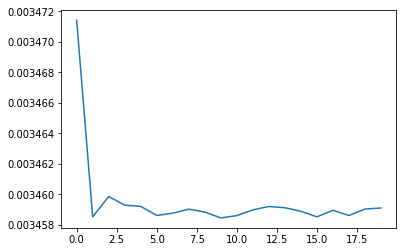

In [75]:
y = hist['val_value_loss'][25:]
plt.plot(np.arange(len(y)), y)

In [ ]:
clr.history.keys()

In [152]:
clr.history['lr'][-1]

1.25

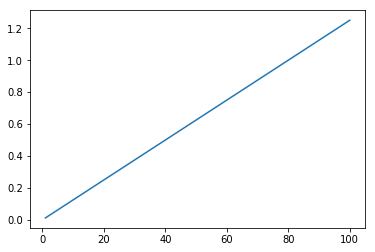

In [151]:
plt.plot(clr.history['iterations'], clr.history['lr'])

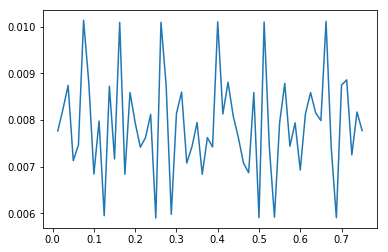

In [167]:
rng = np.s_[:60]
plt.plot(clr.history['lr'][rng], clr.history['loss'][rng])

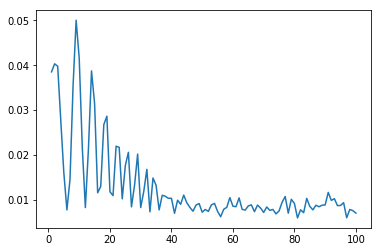

In [154]:
plt.plot(clr.history['iterations'], clr.history['loss'])

In [68]:
hist2 = Out[65]

In [33]:
train_model.save_weights('/ssd/slonik_data/autoencoder_sf_v0.h5')

In [169]:
train_model.load_weights('../slonik_data/autoencoder_v0.h5')

In [ ]:
train_model.evaluate()

### evaluate models

In [20]:
from math import ceil

In [76]:
batch_size = 1024 * 2
valid_steps = ceil(len(features_sf12_valid) / batch_size)
valid_gen = batch_generator_bcolz(features_sf12_valid, batch_size, shuffle=False)
autoencoder.evaluate_generator(valid_gen, steps=valid_steps)
# 0.25 => 0.00328

0.0032881421451767287

In [77]:
batch_size = 1024 * 2
valid_gen = batch_generator_df_bcolz(sf_scores12, features_sf12_valid, batch_size, shuffle=False)
evaluator.evaluate_generator(valid_gen, steps=valid_steps)
# 0.04357 => 5.151884e-09

5.1518849744525145e-09

In [173]:
from math import ceil
batch_size = 1024 * 2
valid_steps = ceil(len(features_sf12_valid) / batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores12[-60000:], features_sf12_valid, batch_size, shuffle=False)
                                    #yielder=lambda f_s: (f_s[0], [f_s[0], f_s[1]]))
train_model.evaluate_generator(valid_gen, steps=valid_steps)
# [0.0037449617413183051, 0.0088122262507677081, 0.0037405556129912537]

# [0.0064739205973843731, 0.0015579963417723774, 0.0064731416421631976]

0.0091104071517785386

In [22]:
train_model.metrics_names

['loss', 'decoded_loss', 'value_loss', 'decoded_acc', 'value_acc']

In [167]:
K.get_value(train_model.optimizer.lr)

0.001

#### see some results of evaluator

In [ ]:
train_mod

In [61]:
from pprint import pprint

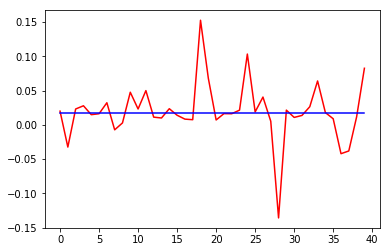

In [172]:
rng = slice(0,40)
dfrng = slice(rng.start+-60000, rng.stop+-60000)
fens = sf_scores12[dfrng].orig_fen
scores = sf_scores12[dfrng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(features_sf12_valid[rng]).squeeze(), 'b')

In [84]:
np.mean(np.square(np.array(scores) - evaluator.predict(features_sf12_valid[rng]).squeeze()))

0.012302580172725733

In [67]:
sf_scores12.score.min(), sf_scores12.score.mean(), sf_scores12.score.max(), sf_scores12.score.std()

(-1.0, 0.015116376857587148, 1.0, 0.091561853816979275)

#### visualize

In [118]:
preds = autoencoder.predict(np.stack([get_feats(p) for p in ps[0:1]]))
[print_feats(p) for p in np.round(preds)]
print('\n')
for p in ps[0:1]:
    print(p)
preds[0][:,:,11]

  ·  ·  ·  ·  ·  ·  ·  ♚
  ·  ·  ·  ·  ·  ·  ·  ·
  ·  ·  ·  ·  ·  ♟  ·  ·
  ♟  ·  ·  ·  ♟  ·  ·  ·
  ·  ·  ·  ·  ·  ·  ♙  ·
  ·  ♙  ·  ·  ·  ·  ·  ♙
  ♙  ·  ·  ·  ·  ·  ♔  ·
  ·  ·  ♖  ·  ·  ·  ·  ·
B to move


B to move
 ·  ·  ·  ·  ·  ♗  ♜  ♚ 
 ·  ·  ·  ♛  ·  ·  ·  · 
 ·  ·  ·  ·  ·  ♟  ·  · 
 ♟  ·  ·  ·  ♟  ♖  ·  · 
 ·  ·  ·  ♝  ♕  ·  ♙  · 
 ·  ♙  ·  ·  ·  ·  ·  ♙ 
 ♙  ·  ·  ·  ·  ·  ♔  · 
 ·  ·  ♖  ·  ·  ·  ·  · 



array([[  1.62972242e-03,   4.52090008e-03,   5.87424776e-03,
          5.01511211e-04,   1.34247937e-03,   5.91424992e-03,
          2.57249223e-03,   5.02845542e-05],
       [  1.09640986e-03,   6.15964690e-03,   3.96589860e-02,
          2.18044128e-02,   5.58355562e-02,   2.52539497e-02,
          9.89863370e-03,   5.07101696e-03],
       [  3.99631681e-03,   8.75882525e-03,   1.62292235e-02,
          2.51737796e-02,   1.70903318e-02,   3.83307692e-04,
          8.38182867e-03,   1.07366836e-03],
       [  4.22662357e-03,   4.84171370e-03,   1.13326721e-02,
          2.72452645e-03,   2.10633059e-03,   7.61086820e-04,
          2.27976101e-03,   4.19372227e-03],
       [  6.94604591e-04,   6.78371114e-04,   9.11953510e-04,
          2.76113348e-03,   1.91220432e-03,   4.98773821e-04,
          7.69313101e-06,   2.69613578e-04],
       [  5.71762724e-03,   9.91462798e-07,   4.38794727e-04,
          2.32832297e-03,   1.31268264e-03,   1.69869151e-03,
          4.06783819e-03,   6.3

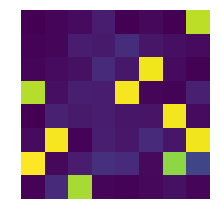

In [119]:
plot_multi(preds.mean(-1), dim=(4,4), figsize=(12,12))

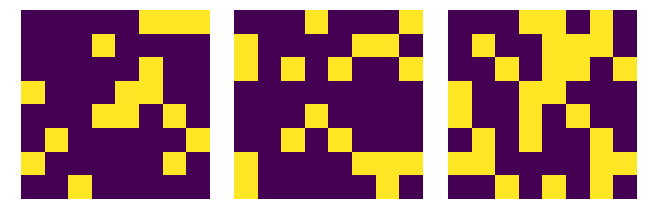

In [120]:
plot_multi([get_feats(p).mean(-1) for p in ps[0:3]], dim=(4,4), figsize=(12,12))

### save encoded versions for nearest neighbors

In [181]:
encoded_10k = encoder.predict(np.stack([get_feats(Position.from_fen(i)) for i in list(data[:10000].fen)]))

In [182]:
encoded_10k.shape

(10000, 4, 4, 2)

### find similar positions

In [131]:
from sklearn.neighbors import NearestNeighbors, LSHForest

In [183]:
nn = LSHForest(20, n_neighbors=3).fit(encoded_10k.reshape(encoded_10k.shape[0], -1))

/usr/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [218]:
n = 9001
pos = Position.from_fen(data.iloc[n].fen)
feats = get_feats(pos)

print(pos)

dist, idxs = nn.kneighbors(encoder.predict(feats[None]).reshape(1, -1))
print(dist)

if idxs[0][0] != n: print('no self match')
for i in idxs[0]:
    if i != n: print(Position.from_fen(data.iloc[i].fen))

W to move
 ·  ·  ·  ·  ♖  ·  ·  · 
 ·  ·  ·  ·  ·  ·  ·  · 
 ·  ·  ♟  ·  ·  ·  ♟  ♞ 
 ·  ·  ·  ♝  ·  ·  ·  ♟ 
 ·  ·  ·  ♚  ♟  ·  ·  ♙ 
 ·  ·  ·  ·  ·  ·  ♙  · 
 ·  ♙  ·  ·  ♔  ♙  ·  · 
 ·  ·  ·  ·  ·  ·  ·  · 

[[  1.19209290e-07   7.56382942e-05   1.27911568e-04]]
W to move
 ·  ·  ·  ·  ·  ·  ·  · 
 ·  ·  ·  ·  ·  ·  ♚  · 
 ·  ·  ♟  ♖  ·  ·  ♟  ♟ 
 ·  ·  ·  ·  ·  ·  ·  · 
 ·  ·  ·  ·  ·  ·  ·  ♙ 
 ·  ·  ·  ·  ♙  ·  ♙  · 
 ·  ·  ·  ·  ·  ♙  ·  · 
 ♜  ·  ·  ·  ·  ♔  ·  · 

W to move
 ·  ·  ·  ·  ·  ·  ·  · 
 ·  ·  ·  ·  ♚  ·  ·  · 
 ·  ·  ·  ·  ·  ♞  ♟  · 
 ·  ·  ·  ·  ·  ·  ·  ♟ 
 ·  ·  ·  ·  ♟  ·  ·  ♙ 
 ·  ·  ·  ·  ♙  ·  ♙  ♗ 
 ·  ·  ·  ·  ·  ♙  ·  · 
 ·  ·  ·  ·  ·  ♔  ·  · 



In [134]:
sf_scores = pd.read_pickle('/ssd/slonik_data/sf_scores.pkl')

In [135]:
len(sf_scores)

295705

In [136]:
591410/2

295705.0

### transfer to smaller model

In [ ]:
# try to copy encoding
tinp = Input((8,8,14))
x = Flatten()(tinp)
x = Dense(128, activation='relu')(x)
x = Dense(128)(x)
tout = Reshape((8,8,4))
tmodel = Model(tinp, tout)
tmodel.compile('adam', 'mse')

In [174]:
def dense_model():
    input_global = Input((26,))
    input_pawn = Input((18,))
    input_piece = Input((68,))
    input_square = Input((148,))
    g = Dense(26)(input_global)
    g = Activation('relu')(g)
    pwn = Dense(18)(input_pawn)
    pwn = Activation('relu')(pwn)
    pc = Dense(24)(input_piece)
    pc = Activation('relu')(pc)
    sq = Dense(32)(input_square)
    sq = Activation('relu')(sq)
    merged = keras.layers.concatenate([g, pwn, pc, sq])
    shared = Dense(64)(merged)
    shared = Activation('relu')(shared)
    output = Dense(1)(shared)
    output = Activation('tanh')(output)
    return [input_global, input_pawn, input_piece, input_square], output
dinputs, doutp = dense_model()
dmodel = Model(dinputs, doutp)
dmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 68)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 148)          0                                            
__________________________________________________________________________________________________
dense_9 (D

In [248]:
inp = Input(shape=(15,))                
x = Dense(10, activation='relu')(inp)
x = Dense(1, activation='sigmoid')(x)

model = Model(inp, x)
X = np.random.rand(2000000,15)
Y = np.random.randint(0,2,size=2000000)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150463). Check your callbacks.
  % delta_t_median)


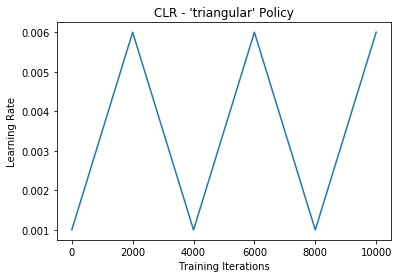

In [252]:
clr_triangular = CyclicLR(mode='triangular')

model.compile(optimizer=Adam(0.1), loss='binary_crossentropy')

model.fit(X, Y, batch_size=2000, nb_epoch=10, callbacks=[clr_triangular], verbose=0)

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


In [251]:
clr_triangular.history.keys()

dict_keys(['lr', 'iterations', 'batch', 'size', 'loss', 'acc'])